<a href="https://colab.research.google.com/github/GYIKOO/UCIMLHackathon21/blob/main/RelationPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pd
import numpy as np

from transformers import get_linear_schedule_with_warmup
import time
import datetime
import random
from keras.preprocessing.sequence import pad_sequences
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
# Config
save_model = Path('bertmodel.h5')

seed_val = 1 # random seed for training

MAX_LEN = 32
batch_size = 16

epochs = 1
checkpoint = 2

n_classes = 3 # num of labels

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
file_id = "1sDoHyJuEGe4R3rkgWp9r0R1zHWXAYGbNjwuuckQDthg"
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('covid_lies.csv', mimetype='text/csv')

In [6]:
df = pd.read_csv('covid_lies.csv')
df.head()

,misconception_id,misconception,tweet,tweet_id,label
0,3,Coronavirus is genetically engineered.,How the COVID-19 outbreak is changing global p...,1.233965e+18,na
1,30,Blowing conch shells destroys coronavirus pote...,Getting coronavirus and then coughing on peopl...,1.233908e+18,na
2,57,Swans and dolphins swimming in Venice canals f...,Disturbing letter about life in COVID-19 ward ...,1.233910e+18,na
3,22,Cocaine cures coronavirus.,How to prevent corona virus?🤔 Use cowdung cake...,1.233948e+18,na
4,32,Observing janata curfew will result in the red...,This is concerning - They must self-insure for...,1.233937e+18,na


# Sample

The table of misconceptions.

In [7]:
miscon_df = df[['misconception_id','misconception']].drop_duplicates(subset='misconception_id').sort_values(by='misconception_id').reset_index(drop=True)
#mini_mdf = miscon_df[:30].reset_index(drop=True)
mini_mdf = miscon_df
mini_mdf

,misconception_id,misconception
0,1,A person can tell if they have coronavirus or ...
1,2,Drinking large amounts of water will protect a...
2,3,Coronavirus is genetically engineered.
3,4,Dean Koontz predicted the pandemic in his 1981...
4,5,The first person infected is a researcher name...
...,...,...
57,58,Water polution decreased in Venice canals foll...
58,59,A Malabar civet was spotted walking the street...
59,60,A pod of humpback whales returned to the Arabi...
60,61,Lions were freed to keep people off the street...


The table of tweets.

In [8]:
tweets_df = df[['tweet_id','tweet']].drop_duplicates(subset='tweet').sort_values(by='tweet_id')
#mini_tdf = tweets_df[:30].reset_index(drop=True)
mini_tdf = tweets_df
mini_tdf = tweets_df.assign(tweet_index = [i for i in range(1,len(mini_tdf)+1)])
mini_tdf

,tweet_id,tweet,tweet_index
3212,1.230000e+18,How long does the new coronavirus remain activ...,1
3827,1.230000e+18,Millimetre wave technology will kill an indivi...,2
1146,1.230000e+18,How do we strengthen our immune systems to fig...,3
5497,1.233905e+18,"When it comes to coronavirus, who is the most ...",4
1624,1.233905e+18,#Coronavirus and China's Tax Response\n\n@USER...,5
...,...,...,...
2262,1.233998e+18,Forget the mask. Here's how to protect yoursel...,4342
3303,1.233998e+18,"Man Who Returned From Malaysia, Dies In Kerala...",4343
4058,1.233998e+18,.@miafarrow Dug up this report on exquisite ki...,4344
4385,1.233998e+18,Washington state health officials are investig...,4345


# Words Embedding

In [9]:
def vectorize(text,MAX_LEN=MAX_LEN):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    input_ids = []
    for t in text:
        # so basically encode tokenizing , mapping sentences to thier token ids after adding special tokens.
        encoded_sent = tokenizer.encode(
            t,  # Sentence which are encoding.
            add_special_tokens=True,  # Adding special tokens '[CLS]' and '[SEP]'
        )
        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN , truncating="post", padding="post")

    attention_masks = []
    for sent in input_ids:
        # Generating attention mask for sentences.
        #   - when there is 0 present as token id we are going to set mask as 0.
        #   - we are going to set mask 1 for all non-zero positive input id.
        att_mask = [int(token_id > 0) for token_id in sent]

        attention_masks.append(att_mask)

    return attention_masks, input_ids

In [10]:
m_text = miscon_df.misconception.values
m_attention_mask, m_input_id = vectorize(m_text)

t_text = tweets_df.tweet.values
t_attention_mask, t_input_id = vectorize(t_text,64)

In [11]:
def get_X_inputs_masks(sample, t_attention_mask, t_input_id, m_attention_mask, m_input_id):
    X_inputs = []
    X_masks = []

    for i in range(0,len(sample)):
        t_index = sample.tweet_index[i]-1
        inputs_temp = t_input_id[t_index].tolist().copy()
        masks_temp = t_attention_mask[t_index].copy()

        m_index = sample.misconception_id[i]-1
        inputs_temp.extend(m_input_id[m_index].tolist())
        masks_temp.extend(m_attention_mask[m_index])

        X_inputs.append(inputs_temp)
        X_masks.append(masks_temp)
    
    X_inputs = np.array(X_inputs)
    return X_inputs, X_masks

# Split Data

In [12]:
!pip install imbalanced-learn

In [13]:
df.groupby('label')['tweet'].count()

label
na     6149
neg     154
pos     288
Name: tweet, dtype: int64

Use -1, 0, 1 to denote label.

In [14]:
sample = pd.merge(df, mini_tdf[['tweet','tweet_index']],
         how = 'left',
         left_on = ('tweet'),
         right_on = ('tweet'))
sample.tweet_index = sample.tweet_index.astype('int64')

temp = sample.label.values
label = []
for i in temp:
  if i == 'na':
    label.append(0)
  elif i == 'neg':
    label.append(-1)
  elif i == 'pos':
    label.append(1)

sample.label = label

sample.head()

,misconception_id,misconception,tweet,tweet_id,label,tweet_index
0,3,Coronavirus is genetically engineered.,How the COVID-19 outbreak is changing global p...,1.233965e+18,0,3058
1,30,Blowing conch shells destroys coronavirus pote...,Getting coronavirus and then coughing on peopl...,1.233908e+18,0,193
2,57,Swans and dolphins swimming in Venice canals f...,Disturbing letter about life in COVID-19 ward ...,1.233910e+18,0,289
3,22,Cocaine cures coronavirus.,How to prevent corona virus?🤔 Use cowdung cake...,1.233948e+18,0,2233
4,32,Observing janata curfew will result in the red...,This is concerning - They must self-insure for...,1.233937e+18,0,1678


In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
over = SMOTE({-1:500,1:600})
under = RandomUnderSampler({0:3000})
resample = [('under',under),('over',over)]
pipeline = Pipeline(steps=resample)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
# oversampling data to reduce the impact of data imbalance
labels = sample.label.values
input_ids, _ = get_X_inputs_masks(sample, t_attention_mask, t_input_id, m_attention_mask, m_input_id)

inputs, labels = pipeline.fit_resample(input_ids, labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [17]:
print(len(labels[labels==-1]),len(labels[labels==0]),len(labels[labels==1]))

500 3000 600


## Class Weight

In [18]:
neg = len(labels[labels==-1])
zero = len(labels[labels==0])
pos = len(labels[labels==1])
total = neg + zero + pos

weight_for_zero = (1 / zero) * (total / 3.0)
weight_for_neg = (1 / neg) * (total / 3.0)
weight_for_pos = (1 / pos) * (total / 3.0)

class_weight = {0: weight_for_zero, -1: weight_for_neg,1: weight_for_pos}

print('Weight for class 0: {:.2f}'.format(weight_for_zero))
print('Weight for class -1: {:.2f}'.format(weight_for_neg))
print('Weight for class 1: {:.2f}'.format(weight_for_pos))

Weight for class 0: 0.46
Weight for class -1: 2.73
Weight for class 1: 2.28


# Single Classifier

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score

def multi_eval(label, prediction):
    acc = accuracy_score(label, prediction)
    print('f1',f1_score(label, prediction, average='weighted'))
    c_matrix = confusion_matrix(label, prediction)
    print('confusion matrix', c_matrix)
    sensitivity = c_matrix[2][2]/(c_matrix[2][0]+c_matrix[2][1]+c_matrix[2][2])
    specificity = c_matrix[0][0]/(c_matrix[0][0]+c_matrix[0][1]+c_matrix[0][2])
    print('')
    return acc, sensitivity, specificity

def clf_predict(X_val, model_name):
    '''
    comparing the return result with the Y_val
    e.g.
    from sklearn.metrics import accuracy_score
    accuracy_score(Y_val, forest_prediction)
    '''
    clf = load(model_name)
    pred = clf.predict(X_val)
    return pred

## KFold

In [20]:
from sklearn.model_selection import KFold
def cv_split(X, Y, n_split=5):
    kf = KFold(n_splits=n_split,shuffle=True,random_state=84735)

    X_trains = []
    X_tests = []
    for train,test in kf.split(X):
        X_train = []
        X_test = []
        for i in train:
            X_train.append(X[i])
        for i in test:
            X_test.append(X[i])
        X_trains.append(X_train)
        X_tests.append(X_test)

    Y_trains = []
    Y_tests = []
    for train, test in kf.split(Y):
        Y_train = []
        Y_test = []
        for i in train:
            Y_train.append(Y[i])
        for i in test:
            Y_test.append(Y[i])
        Y_trains.append(Y_train)
        Y_tests.append(Y_test)

    return X_trains, X_tests, Y_trains, Y_tests

In [21]:
X_trains, X_tests, Y_trains, Y_tests = cv_split(inputs, labels)

## Random Forest

In [22]:
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

def foresttrain(X_train, Y_train, model_name):
    '''
    Train the random forest classifier and save to local.
    :param X_train:
    :param Y_train:
    '''
    forest = RandomForestClassifier(n_estimators=100, oob_score=True, n_jobs=3, class_weight = class_weight) #n_job is n of CPU cores assigned
    forest.fit(X_train, Y_train)
    dump(forest, model_name)

In [23]:
forest_train_preds = []
forest_preds = []
forest_cv_result = {'scores':[],'sensitivity':[],'specificity':[]}

for i in range(5):
  X_train = X_trains[i]
  X_test = X_tests[i]
  Y_train = Y_trains[i]
  Y_test = Y_tests[i]

  foresttrain(X_train, Y_train, 'forest.joblib')
  forest_train_preds.append(clf_predict(X_train,'forest.joblib'))
  pred = clf_predict(X_test,'forest.joblib')
  forest_preds.append(pred)

  acc, sen, spe = multi_eval(Y_test, pred)
  forest_cv_result['scores'].append(acc)
  forest_cv_result['sensitivity'].append(sen)
  forest_cv_result['specificity'].append(spe)

f1 0.8928064760274605
confusion matrix [[ 86  15   7]
 [  4 566   5]
 [  5  47  85]]

f1 0.9023777003863525
confusion matrix [[ 74  32   2]
 [  2 597   8]
 [  3  29  73]]

f1 0.914274541714182
confusion matrix [[ 84  16   2]
 [  3 599   8]
 [  8  30  70]]

f1 0.8974369641935814
confusion matrix [[ 57  21   1]
 [  3 615   9]
 [  2  43  69]]

f1 0.8854376671805616
confusion matrix [[ 67  33   3]
 [  1 576   4]
 [  3  44  89]]



In [24]:
from statistics import mean

print('Avg Scores:', mean(forest_cv_result['scores']), '\n',
   'Avg Sensitivity:', mean(forest_cv_result['sensitivity']), '\n',
   'Avg Sepcificity:', mean(forest_cv_result['specificity']))

Avg Scores: 0.9041463414634147 
 Avg Sensitivity: 0.6446998244382485 
 Avg Sepcificity: 0.7354030634962326


## Ada Boost

In [25]:
from sklearn.ensemble import AdaBoostClassifier

def adatrain(X_train, Y_train, model_name):
    '''
    Train the random forest classifier and save to local.
    :param X_train:
    :param Y_train:
    '''
    ada = AdaBoostClassifier(n_estimators=100)
    ada.fit(X_train, Y_train)
    dump(ada, model_name)

In [26]:
ada_train_preds = []
ada_preds = []
ada_cv_result = {'scores':[],'sensitivity':[],'specificity':[]}

for i in range(5):
  X_train = X_trains[i]
  X_test = X_tests[i]
  Y_train = Y_trains[i]
  Y_test = Y_tests[i]

  adatrain(X_train, Y_train, 'ada.joblib')
  ada_train_preds.append(clf_predict(X_train,'ada.joblib'))
  pred = clf_predict(X_test,'ada.joblib')
  ada_preds.append(pred)

  acc, sen, spe = multi_eval(Y_test, pred)
  ada_cv_result['scores'].append(acc)
  ada_cv_result['sensitivity'].append(sen)
  ada_cv_result['specificity'].append(spe)

f1 0.8284453474532176
confusion matrix [[ 80  16  12]
 [ 17 543  15]
 [ 15  58  64]]

f1 0.8390491251446549
confusion matrix [[ 68  27  13]
 [ 10 556  41]
 [ 10  31  64]]

f1 0.8301842005814077
confusion matrix [[ 63  22  17]
 [ 17 566  27]
 [ 10  43  55]]

f1 0.8205347248933107
confusion matrix [[ 49  20  10]
 [ 18 581  28]
 [  8  57  49]]

f1 0.7993086264560432
confusion matrix [[ 61  27  15]
 [ 13 536  32]
 [ 11  60  65]]



In [27]:
from statistics import mean

print('Avg Scores:', mean(ada_cv_result['scores']), '\n',
   'Avg Sensitivity:', mean(ada_cv_result['sensitivity']), '\n',
   'Avg Sepcificity:', mean(ada_cv_result['specificity']))

Avg Scores: 0.8292682926829268 
 Avg Sensitivity: 0.4987404182657397 
 Avg Sepcificity: 0.6401007206919199


## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression

def lrtrain(X_train, Y_train, model_name):
    lr = LogisticRegression(max_iter=200,solver='liblinear',class_weight=class_weight)
    lr.fit(X_train, Y_train)
    dump(lr,model_name)

In [29]:
lr_train_preds = []
lr_preds = []
lr_cv_result = {'scores':[],'sensitivity':[],'specificity':[]}

for i in range(5):
  X_train = X_trains[i]
  X_test = X_tests[i]
  Y_train = Y_trains[i]
  Y_test = Y_tests[i]

  lrtrain(X_train, Y_train, 'lr.joblib')
  lr_train_preds.append(clf_predict(X_train,'lr.joblib'))
  pred = clf_predict(X_test,'lr.joblib')
  lr_preds.append(pred)

  acc, sen, spe = multi_eval(Y_test, pred)
  lr_cv_result['scores'].append(acc)
  lr_cv_result['sensitivity'].append(sen)
  lr_cv_result['specificity'].append(spe)

f1 0.7869560482484486
confusion matrix [[ 82  15  11]
 [ 40 487  48]
 [ 23  41  73]]

f1 0.7918572291933222
confusion matrix [[ 67  29  12]
 [ 31 508  68]
 [ 12  26  67]]

f1 0.8051572337897385
confusion matrix [[ 72  17  13]
 [ 32 512  66]
 [ 12  28  68]]

f1 0.7947499333990335
confusion matrix [[ 54  17   8]
 [ 49 521  57]
 [ 17  30  67]]

f1 0.785591100612801
confusion matrix [[ 67  21  15]
 [ 37 495  49]
 [ 15  42  79]]



In [30]:
from statistics import mean

print('Avg Scores:', mean(lr_cv_result['scores']), '\n',
   'Avg Sensitivity:', mean(lr_cv_result['sensitivity']), '\n',
   'Avg Sepcificity:', mean(lr_cv_result['specificity']))

Avg Scores: 0.7851219512195122 
 Avg Sensitivity: 0.5938346468480251 
 Avg Sepcificity: 0.6839083446522957


# Voting Emsemble

## Train Weight

In [31]:
def train_weight(preds, label, num=3):
    forest_pre = preds['forest'].values
    ada_pre = preds['ada'].values
    lr_pre = preds['lr'].values

    weight = [1]*num
    for i in range(0,len(label)):
        update = [0]*num
        wrong = 0
        
        if forest_pre[i] == label[i]:
            update[0] = 1
        else:
            wrong += 1

        if ada_pre[i] == label[i]:
            update[1] = 1
        else:
            wrong += 1

        if lr_pre[i] == label[i]:
            update[2] = 1
        else:
            wrong += 1

        for j in range(0,num):
            weight[j] += update[j]* wrong/num

    total_weight = sum(weight)
    for j in range(0, num):
        weight[j] = weight[j]/total_weight
    return weight

## Self-defined Voting

In [32]:
from random import randrange
def WMVEpredict(weight, preds, use_softmax=False):
    softmax = torch.nn.Softmax()
    result = []
    forest_pre = preds['forest'].values
    ada_pre = preds['ada'].values
    lr_pre = preds['lr'].values

    for i in range(0, len(ada_pre)):
        labels = torch.FloatTensor([0,0,0])
        labels[forest_pre[i]] += weight[0]
        labels[ada_pre[i]] += weight[1]
        labels[lr_pre[i]] += weight[2]

        if use_softmax:
            votes = softmax(labels)
        else:
            votes = labels

        if torch.argmax(votes)==0:
            result.append(0)
        elif torch.argmax(votes)==1:
            result.append(1)
        else:
            result.append(-1)
    return result

In [44]:
voting_preds = []
voting_cv_result = {'scores':[],'sensitivity':[],'specificity':[]}
for i in range(5):
  X_train = X_trains[i]
  X_test = X_tests[i]
  Y_train = Y_trains[i]
  Y_test = Y_tests[i]

  classfiers_train_pred = pd.DataFrame({'forest': forest_train_preds[i], 'ada': ada_train_preds[i], 'lr': lr_train_preds[i]})
  classfiers_val_pred = pd.DataFrame({'forest': forest_preds[i], 'ada': ada_preds[i], 'lr': lr_preds[i]})

  #weight = train_weight(classfiers_train_pred,Y_train)
  #print('weight', weight)

  weight = [0.55, 0.3, 0.4]  

  pred = WMVEpredict(weight, classfiers_val_pred, use_softmax=True)
  voting_preds.append(pred)

  acc, sen, spe = multi_eval(Y_test, pred)
  voting_cv_result['scores'].append(acc)
  voting_cv_result['sensitivity'].append(sen)
  voting_cv_result['specificity'].append(spe)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


f1 0.8729651711820225
confusion matrix [[ 83  17   8]
 [ 11 553  11]
 [ 11  42  84]]

f1 0.8678448324079633
confusion matrix [[ 70  30   8]
 [  5 574  28]
 [  6  29  70]]

f1 0.8845202015887517
confusion matrix [[ 75  19   8]
 [  9 580  21]
 [  8  28  72]]

f1 0.8721776202803244
confusion matrix [[ 55  18   6]
 [ 14 597  16]
 [  6  41  67]]

f1 0.8507908207167136
confusion matrix [[ 68  28   7]
 [  7 558  16]
 [  9  49  78]]



In [50]:
from statistics import mean

print('Avg Scores:', mean(voting_cv_result['scores']), '\n',
   'Avg Sensitivity:', mean(voting_cv_result['sensitivity']), '\n',
   'Avg Sepcificity:', mean(voting_cv_result['specificity']))

Avg Scores: 0.8741463414634146 
 Avg Sensitivity: 0.6215441458950081 
 Avg Sepcificity: 0.7016714981433153


# Result Visualization

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
sns.set(font_scale=1.4)

clf = ['Random Forest']*5 + ['Ada']*5 + ['LR']*5 + ['Voting']*5

sen = forest_cv_result['sensitivity']+ada_cv_result['sensitivity']+lr_cv_result['sensitivity']+voting_cv_result['sensitivity']
spe = forest_cv_result['specificity']+ada_cv_result['specificity']+lr_cv_result['specificity']+voting_cv_result['specificity']
scores = forest_cv_result['scores'] + ada_cv_result['scores'] + lr_cv_result['scores'] + voting_cv_result['scores']

df = pd.DataFrame({'Classifier':clf,
                   'Accuracy Score':scores,
                   'Sensitivity':sen,
                   'Specificity':spe,
                   'CV':[1,2,3,4,5]*4})

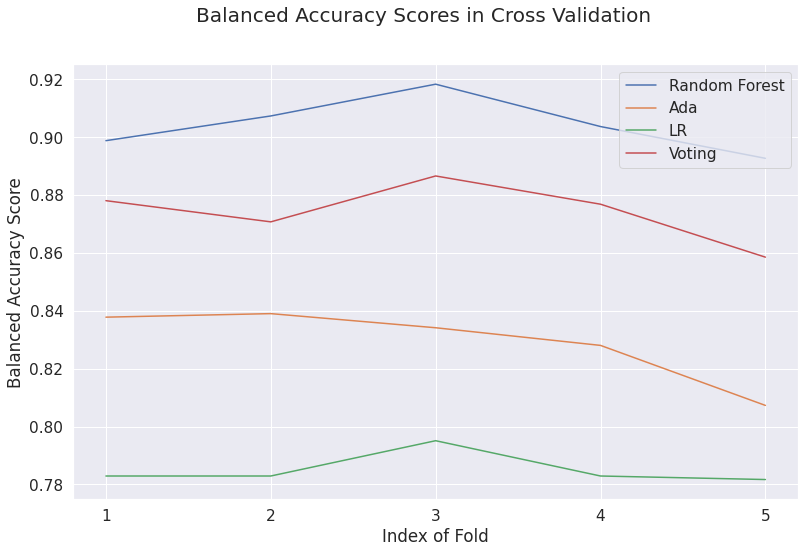

In [47]:
f, a = plt.subplots(1,1,figsize=(13,8))
f = sns.lineplot(x='CV',y='Accuracy Score',hue='Classifier',data=df)
a.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('Balanced Accuracy Scores in Cross Validation', fontsize=20)
plt.ylabel('Balanced Accuracy Score')
plt.xlabel('Index of Fold')
plt.legend()
plt.show()

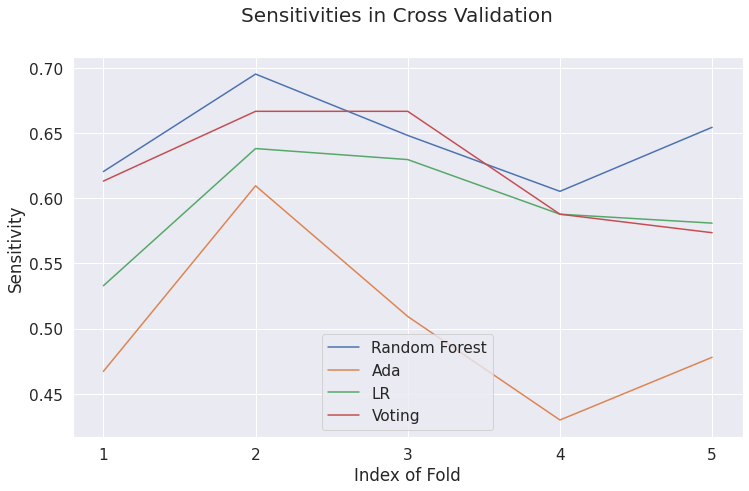

In [48]:
f, a = plt.subplots(1,1,figsize=(12,7))
f = sns.lineplot(x='CV',y='Sensitivity',hue='Classifier',data=df)
a.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('Sensitivities in Cross Validation', fontsize=20)
plt.ylabel('Sensitivity')
plt.xlabel('Index of Fold')
plt.legend()
plt.show()

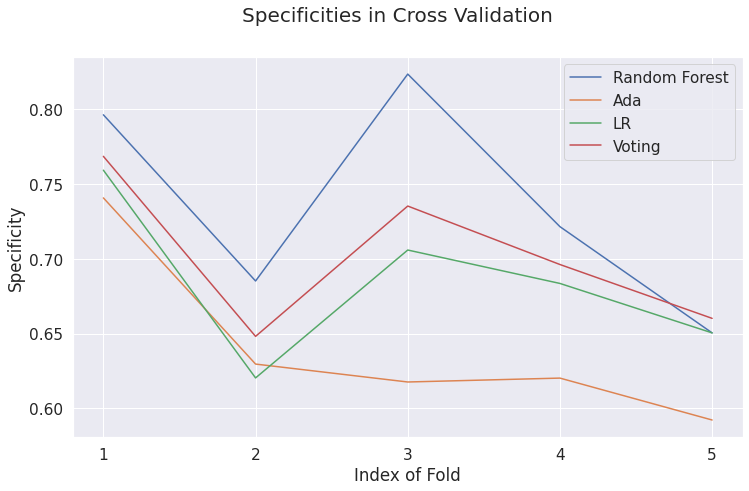

In [49]:
f, a = plt.subplots(1,1,figsize=(12,7))
f = sns.lineplot(x='CV',y='Specificity',hue='Classifier',data=df)
a.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('Specificities in Cross Validation', fontsize=20)
plt.ylabel('Specificity')
plt.xlabel('Index of Fold')
plt.legend()
plt.show()